In [1]:
#! pip install gym torch
#! pip install pygame
#! pip show gym
#! pip install --upgrade gym

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import os
from PIL import Image


 Actor and Critic Networks

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, device):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(state_dim, 128)
        
        # Assuming action_dim is the dimension of the continuous action space
        self.action_mean = nn.Linear(128, action_dim)  # Output the mean of the action distribution
        self.action_std = nn.Linear(128, action_dim)  # Output the standard deviation of the action distribution
        self.value_layer = nn.Linear(128, 1)
        
        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state = F.relu(self.affine(state))
        
        state_value = self.value_layer(state)
        
        action_mean = self.action_mean(state)
        # Preventing action_std from exploding
        action_log_std = self.action_std(state)
        action_std = torch.exp(torch.clamp(action_log_std, min=-0.5, max=1.0))

        # Debugging: Check for NaN values and handle them
        if torch.isnan(action_mean).any() or torch.isnan(action_std).any():
            print("NaN detected in action outputs")
            action_mean = torch.where(torch.isnan(action_mean), torch.zeros_like(action_mean), action_mean)
            action_std = torch.where(torch.isnan(action_std), torch.ones_like(action_std), action_std)

        action_dist = Normal(action_mean, action_std)
        action = action_dist.sample()
        
        self.logprobs.append(action_dist.log_prob(action).sum())
        self.state_values.append(state_value)
        
        return action




    def calculateLoss(self, gamma=0.99, entropy_weight=0.1):
        # calculating discounted rewards:
        rewards = []
        dis_reward = 100
        for reward in reversed(self.rewards):
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.action_mean.weight.device)  # Ensure on correct device
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-6)

        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward - value
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward.unsqueeze(0))
            
            # Entropy for exploration (assumes logprob is for current action distribution)
            entropy = -logprob.mean()
            loss += (action_loss + value_loss - entropy_weight * entropy)

        return loss



    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]


Initialize the Environment and Models:

In [4]:
render = False
gamma = 0.99
lr = 0.001
betas = (0.9, 0.999)
random_seed = 543

torch.manual_seed(random_seed)

env = gym.make('LunarLander-v2', continuous=True, render_mode="rgb_array")
#env.seed(random_seed)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Training on CPU.")




def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# policy.apply(init_weights)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

policy = ActorCritic(state_dim, action_dim, device).to(device)
policy.load_state_dict(torch.load("./preTrained/LunarLander_9800.pth"))
policy.to(device)  # Ensure the model is on the right device


optimizer = optim.Adam(policy.parameters(), lr=lr, betas=betas)
print(lr,betas)

CUDA is available. Training on GPU.
0.001 (0.9, 0.999)


In [5]:
from tqdm import tqdm
import numpy as np
import torch

episode_rewards = []
episode_losses = []

running_reward = 0
entropy_weight = 0.01
gamma = 0.99  # Ensure gamma is defined
render = False  # Define whether to render the environment

for i_episode in tqdm(range(9801,20001)):
    state = env.reset()  # Reset environment and get initial state
    state = np.array(state[0])  
    episode_reward = 0

    for t in range(10000):  # Limit each episode to 10000 steps
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # Shape becomes (1, 8)
        action = policy(state)
        action_cpu = action.cpu().detach().numpy() 
        info = env.step(action_cpu[0])
        state, reward, done = info[0], info[1], info[2]
        state = np.array(state)  # Extract the actual state array from next state

        policy.rewards.append(reward)
        episode_reward += reward

        if i_episode % 200 == 0:
            img = env.render()  # Capture the image
            img = Image.fromarray(img)
            os.makedirs(f'./gif/{i_episode}', exist_ok=True) 
            img.save(f'./gif/{i_episode}/{t}.jpg')  # Save frames as images

        if done:
            break

    episode_rewards.append(episode_reward)
    running_reward += episode_reward  # Update cumulative reward

    # Update and train policy
    optimizer.zero_grad()
    loss = policy.calculateLoss(gamma)  # Just pass gamma; entropy_weight has a default value
    loss.backward()
    optimizer.step()
    policy.clearMemory()
    episode_losses.append(loss)

    # Periodic logging and model saving
    if i_episode % 200 == 0:
        avg_reward = running_reward / 200
        print(f'Episode {i_episode}\tAverage Reward: {avg_reward}')
        print(f"currnt loss: ", loss)
        running_reward = 0  # Reset running reward
        os.makedirs(f'./preTrained', exist_ok=True) 
        model_path = f'./preTrained/LunarLander_{i_episode}.pth'
        torch.save(policy.state_dict(), model_path)
        print(f"Model saved: {model_path}")




# Optionally plot rewards or other statistics


  0%|          | 0/3799 [00:00<?, ?it/s]

/home/kamil/miniconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_42869/3060092582.py:64: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward.unsqueeze(0))
  5%|▌         | 200/3799 [00:36<20:29,  2.93it/s]

Episode 6400	Average Reward: -615.9045280257534
currnt loss:  tensor([[-667025.5625]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_6400.pth


 11%|█         | 400/3799 [01:22<18:42,  3.03it/s]

Episode 6600	Average Reward: -1032.3092755300124
currnt loss:  tensor([[-915200.]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_6600.pth


 16%|█▌        | 600/3799 [02:05<14:50,  3.59it/s]

Episode 6800	Average Reward: -877.6303244101525
currnt loss:  tensor([[-754106.8125]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_6800.pth


 21%|██        | 800/3799 [02:41<14:28,  3.45it/s]

Episode 7000	Average Reward: -613.5069743397996
currnt loss:  tensor([[-785167.3750]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_7000.pth


 26%|██▋       | 1000/3799 [03:19<16:25,  2.84it/s]

Episode 7200	Average Reward: -678.4090514010918
currnt loss:  tensor([[-1530538.8750]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_7200.pth


 32%|███▏      | 1200/3799 [04:03<15:57,  2.71it/s]

Episode 7400	Average Reward: -779.5723271394115
currnt loss:  tensor([[-1491065.8750]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_7400.pth


 37%|███▋      | 1401/3799 [04:47<11:11,  3.57it/s]

Episode 7600	Average Reward: -786.0695349386982
currnt loss:  tensor([[-1124145.2500]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_7600.pth


 42%|████▏     | 1601/3799 [05:28<12:01,  3.05it/s]

Episode 7800	Average Reward: -716.3047283497706
currnt loss:  tensor([[-2046606.5000]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_7800.pth


 47%|████▋     | 1800/3799 [06:11<17:30,  1.90it/s]

Episode 8000	Average Reward: -842.129038759423
currnt loss:  tensor([[-3745674.5000]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_8000.pth


 53%|█████▎    | 2000/3799 [07:02<22:16,  1.35it/s]

Episode 8200	Average Reward: -1080.525074820581
currnt loss:  tensor([[-1618955.2500]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_8200.pth


 58%|█████▊    | 2200/3799 [07:53<12:26,  2.14it/s]

Episode 8400	Average Reward: -1094.7675686894931
currnt loss:  tensor([[-2268637.]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_8400.pth


 63%|██████▎   | 2400/3799 [08:44<09:48,  2.38it/s]

Episode 8600	Average Reward: -1141.5818371479236
currnt loss:  tensor([[-2282013.7500]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_8600.pth


 68%|██████▊   | 2600/3799 [09:32<07:00,  2.85it/s]

Episode 8800	Average Reward: -1086.198136624777
currnt loss:  tensor([[-1265528.2500]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_8800.pth


 74%|███████▎  | 2800/3799 [10:23<06:38,  2.51it/s]

Episode 9000	Average Reward: -1112.9151482634218
currnt loss:  tensor([[-1770511.8750]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_9000.pth


 79%|███████▉  | 3000/3799 [11:15<12:03,  1.10it/s]

Episode 9200	Average Reward: -1112.386112154606
currnt loss:  tensor([[-3323845.5000]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_9200.pth


 84%|████████▍ | 3200/3799 [12:06<05:51,  1.71it/s]

Episode 9400	Average Reward: -1114.8756225184918
currnt loss:  tensor([[-5123647.5000]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_9400.pth


 90%|████████▉ | 3401/3799 [12:54<01:57,  3.38it/s]

Episode 9600	Average Reward: -1062.3674882193448
currnt loss:  tensor([[-2014545.1250]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_9600.pth


 95%|█████████▍| 3600/3799 [13:45<01:45,  1.89it/s]

Episode 9800	Average Reward: -1114.4654840669923
currnt loss:  tensor([[-3412042.]], device='cuda:0', grad_fn=<AddBackward0>)
Model saved: ./preTrained/LunarLander_9800.pth


100%|██████████| 3799/3799 [14:32<00:00,  4.35it/s]


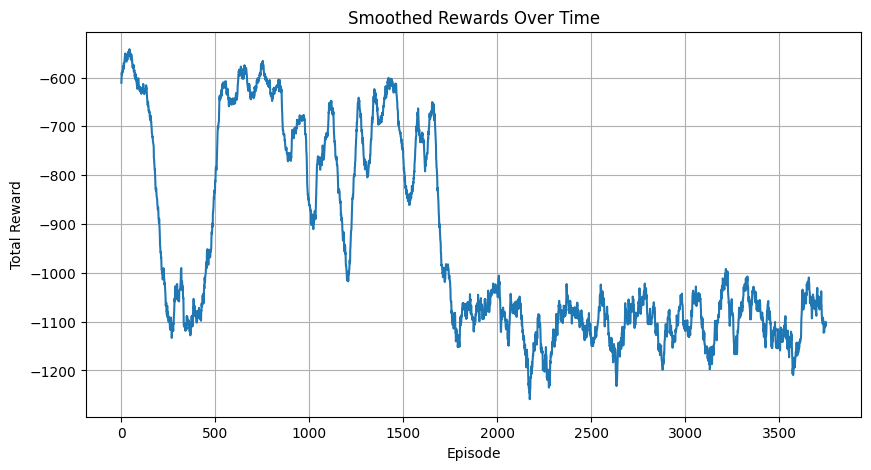

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size):
    """ Computes moving average using a given window size. """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'valid')

# Sample usage with your rewards data
smoothed_rewards = moving_average(episode_rewards, window_size=50)  # Window size can be adjusted

# Plot the smoothed rewards
plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards)
plt.title("Smoothed Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


In [19]:
print(episode_losses[0])

loss_array = episode_losses[0].numpy()

# Optionally convert to Python list
loss_list = loss_array.tolist()

tensor([[-1396984.7500]], device='cuda:0', grad_fn=<AddBackward0>)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

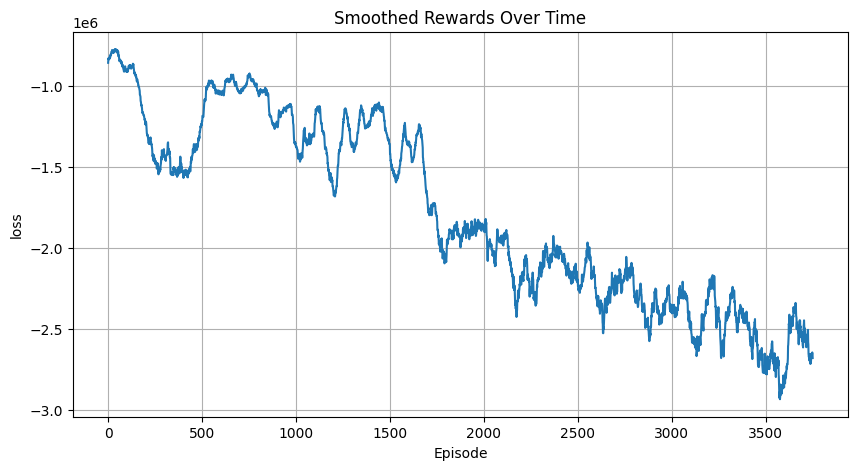

In [29]:
# Sample usage with your rewards data
episode_losses_cpu = [x[0][0].cpu().detach().numpy() for x in episode_losses]
#print(episode_losses[0][0][0].cpu().detach().numpy() )  # Convert each tensor to CPU and then to NumPy
smoothed_rewards = moving_average(episode_losses_cpu, window_size=50)  # Window size can be adjusted

# Plot the smoothed rewards
plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards)
plt.title("Smoothed Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("loss")
plt.grid(True)
plt.show()

In [ ]:
#!pip install opencv-python

In [ ]:
import cv2
import numpy as np
from time import sleep
import os 

render = False
save_gif = True

os.makedirs('./gif', exist_ok=True)  # Ensure the gif directory exists

for i_episode in range(1,2):
    state = env.reset()  # Reset environment and get initial state
    state = np.array(state[0])  
    episode_reward = 0

    for t in range(10000):  # Limit each episode to 10000 steps
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # Shape becomes (1, 8)
        action = policy(state)
        action_cpu = action.cpu().detach().numpy() 
        info = env.step(action_cpu[0])
        state, reward, done = info[0], info[1], info[2]
        state = np.array(state) 

        img = env.render()  # Capture the image
        if render:
            cv2.imshow('Game', img)
            sleep(50)
            cv2.waitKey(1)  # Refresh the display window

        if save_gif:
            img = Image.fromarray(img)
            img.save(f'./gif/{t}.jpg')  # Save frames as images

        running_reward += reward
        if done:
            print("Done!")
            print(f'Episode {i_episode}\tReward: {running_reward}')
            break

env.close()
cv2.destroyAllWindows()  # Make sure to close the OpenCV window


Done!
Episode 1	Reward: -140510.6683609279
